In [69]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import reduce
import matplotlib.cm as cm
import scipy

In [70]:
L = 3 # Number of qubits
d = 2**L # Dimension of Hilbert space

In [71]:
psi = np.zeros(2**L)
psi[0] = 1/np.sqrt(2)
psi[-1] = 1/np.sqrt(2)
rho = np.outer(psi, psi)

In [72]:
# Define Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
paulis = np.array([X, Y, Z])

def get_projectors(measure_settings: np.ndarray):
    """
    Parameters:
        measure_settings: m by L array of 0, 1, or 2 determining Pauli basis
            where m is number of measurement settings
    Returns:
        Length md list of random Pauli basis projector vectors,
    """
    eigvecs = np.array([ np.linalg.eig(sigma)[1] for sigma in paulis ])
    # Number of qubits
    m = measure_settings.shape[0]
    d = 2**measure_settings.shape[1] # d = 2^L

    # Set of dxd projectors for each basis for each measurement setting
    P = np.zeros((m, d, d, d), dtype="complex128")

    for j, pauli_idx in enumerate(measure_settings):

        pauli_eigs_l = eigvecs[pauli_idx]

        # Get all combinations of 1 eigenvector from each pauli across L paulis
        eigs_sets = list(product(*pauli_eigs_l)) # 2^L total

        for k, set in enumerate(eigs_sets):
            # Tensor product all eigenvectors
            v_k = reduce(np.kron, set)
            # Form projector onto eigenspace
            proj_k = np.outer(np.conj(v_k), v_k) # this would do x_i x_i ^*
            P[j, k, :, :] = proj_k
            # P[j, k, :] = v_k # just return x_i

    return P

In [73]:
def sampling_operator(U: np.ndarray, Pk: np.ndarray):
    """
    Parameters:
        U: dxd density matrix
        Pk: m x d x d x d array of projection operators
    Returns:
        A(U) = [ [tr(UP_1), ...], ..., [..., tr(UP_md)] ]
    """
    return np.array([[
            np.real(np.trace(P @ U)) for P in P_setting ]
        for P_setting in Pk ])

In [74]:
N = 100 # Num. of measurement repeats
m = 15 # Num. of measurement settings
measures_test = np.random.randint(0, 3, size=(m, L))

In [75]:
eigvecs = np.array([ np.linalg.eig(sigma)[1] for sigma in paulis ])

In [76]:
proj_k = get_projectors(measures_test)
proj_flat = proj_k.reshape((m*d, d, d))

In [77]:
# Each measurement setting defines a new basis which is some multinomial distribution
probabilities = sampling_operator(rho, proj_k)
samples = np.array([ np.random.multinomial(N, basis_probs) for basis_probs in probabilities ])

# Normalize and flatten
Y = samples.flatten() / N

$$
C_n = \frac{1}{d} \mathbb{I}, \quad C_n^{-1/2} = \sqrt{d} \, \mathbb{I}
$$

$$
X_i = y_i C_n^{-1/2} x_i x_i^* C_n^{-1/2}
$$

In [78]:
inv_sqrt_C_n = np.sqrt(d) * np.eye(d)

In [79]:
def grad_F(sigma_0):
    def get_Xi(i: int):
        return Y[i] * inv_sqrt_C_n @ proj_flat[i] @ inv_sqrt_C_n
    
    exp_X_Q = 0
    for i in range(m*d):
        Xi = get_Xi(i)
        if (Y[i] >= 1e-10): # If measurement nonzero
            exp_X_Q += Xi / np.trace(Xi @ sigma_0)

    T = (1 / (m*d)) * exp_X_Q

    return np.eye(d) - T

In [80]:
def grad_step(sigma, eta=1):

    factor = np.eye(d) - eta * grad_F(sigma)
    return factor @ sigma @ factor

In [81]:
# Random initialization
sigma = np.random.random((d, d)) + np.random.random((d, d)) * 1j
eta = 0.1

steps = 0

while (steps < 1000):
    sigma = grad_step(sigma)
    steps += 1

In [82]:
sigma /= np.trace(sigma)

Text(0.5, 0, '$|\\rho_{jk}|$')

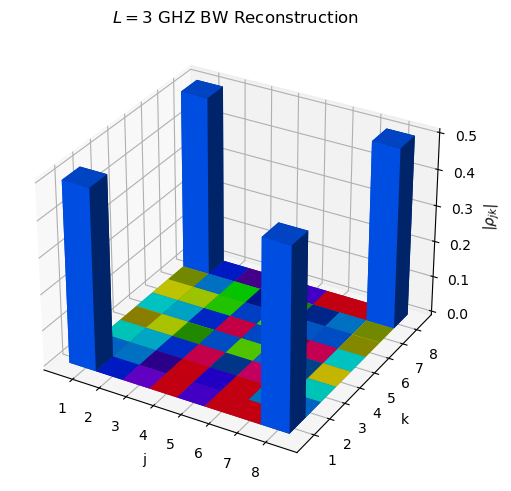

In [83]:
from matplotlib.colors import Normalize

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection="3d")
_x = np.arange(0.5, d + .5, 1)
_y = np.arange(0.5, d + .5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

amplitudes = np.abs(sigma)
phases = np.angle(sigma)

top = amplitudes.ravel()
bottom = np.zeros_like(top)
width = depth = 1


ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + phases.flatten())/(2*np.pi)))
ax.set_title("$L = 3$ GHZ BW Reconstruction")
ax.set_xlabel("j")
ax.set_ylabel("k")
ax.set_zlabel(r"$|\rho_{jk}|$")

# fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(3.9, 3.9+2*np.pi), cmap=plt.cm.hsv))

In [84]:
def compute_fidelity(rho: np.ndarray, sigma: np.ndarray):
        """Returns the fidelity between the two states"""
        sqrt_rho = scipy.linalg.sqrtm(rho)
        return np.real(np.trace(scipy.linalg.sqrtm(sqrt_rho @ sigma @ sqrt_rho)))

In [85]:
compute_fidelity(rho, sigma)

1.0000000000000003886

In [86]:
cs_sweep = np.genfromtxt("cs_msweep.csv", delimiter=',')
bw_sweep = np.genfromtxt("bw_msweep.csv", delimiter=',')

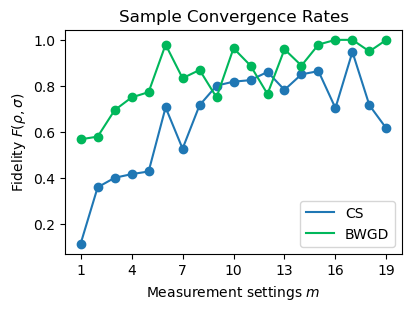

In [108]:
fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

m_min = 1
m_max = 20
n_msettings = np.arange(m_min, m_max, 1)

ax.plot(n_msettings, cs_sweep, label="CS")
ax.plot(n_msettings, bw_sweep, label="BWGD", c="#00b75b")
ax.scatter(n_msettings, cs_sweep)
ax.scatter(n_msettings, bw_sweep, c="#00b75b")

ax.set_xlabel("Measurement settings $m$")
ax.set_ylabel(r"Fidelity $F(\rho, \sigma)$")
ax.set_title("Sample Convergence Rates")
ax.legend()

_ = ax.set_xticks(np.arange(1, 20, 3))